Introduction
------------

This demo (Part 5b) is similar to Part 5a but, instead, focuses on cusotmized loss function that may lead to better mask predictions. See `polarity_model.make_seq2seq_training_data2()` and `cf_models.filter_predict_loss()` for more details. Both part 5a and 5b are based on demo part 5.

As in demo 5, we will focus on CF ensemble learning methods by directly predicting the reliability of each probability score from the base classifiers (users) in both `R` and `T`.  

Specicially, given `T` (rating matrix of the test set) for which we wish to predict its corresponding class labels, we will break down this predictive task into the following subproblems: 

1. Predict reliability of `T`; that is, predict T's probability filter (reliability matrix) where 0s represent unreilable entries (e.g., FPs and FNs) and 1s represent reliable entries (e.g., TPs and TNs)
  - The reliability of `R` is known since we know the (true) labels for the training set. 

2. Run a chosen collaborative filtering algorithm that reestimates the probability scores in `R` and `T` using the predicted filters obtained from step 1.
  - Recall from **Demo Part 1 and 2** that the purpose of probaiblity filter is to help us select the entries of R and T that will enter the optimization objective (see Part 2) while the remaining entries are left out; that is, we wish to find the latent factors for users (classifiers) and items (data) such that either the probability score (or the label depending on loss function) can be well-approximated via the latent factor representation.
  - Reliable entries will enter the optimization objectve whereas unreliable entries are typically left out (unless your loss function somehow can take into account of these entries, see C-square loss for an example)

3. Once we get `Th` (the re-estimated `T`), we will then combine their ratings to formulate our final class label predictions as usual (e.g., mean, majority vote, stacking)

In [1]:
#@title Import Basic Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import os, sys

# Colab 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Plotting
import matplotlib.pylab as plt
# %matplotlib inline

from matplotlib.pyplot import figure
import seaborn as sns
from IPython.display import display

# Progress
from tqdm import tqdm

################################################################
# Configure system environment
# - Please modify input_dir according to your local enviornment
#
################################################################

cur_dir = os.getcwd()
project_dir = 'machine_learning_examples/cf_ensemble'
if IN_COLAB: 
    # Run this demo on Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Parameters for data
    input_dir = f"/content/drive/MyDrive/Colab Notebooks/{project_dir}"
    # /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/data/data-is-life

    sys.path.append(input_dir)
else: 
    input_dir = cur_dir
    
if input_dir != cur_dir: 
    sys.path.append(input_dir)
    print(f"> Adding {input_dir} to sys path ...")
    print(sys.path)

Mounted at /content/drive
> Adding /content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble to sys path ...
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble', '/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble']


In [2]:
#@title Import Tensorflow and CF-Related Libraries
import tensorflow as tf
print(tf.__version__)
# import tensorflow_probability as tfp
# tfd = tfp.distributions
from tensorflow import keras

# from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
# tf.keras.backend.set_floatx('float64')
#################################################################

# Scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#################################################################

# CF-ensemble-specific libraries
import utils_stacking as ustk
import utils_classifier as uclf
import utils_sys as usys
import utils_cf as uc 
import polarity_models as pmodel
from polarity_models import Polarity
import scipy.sparse as sparse
from utils_sys import highlight
import evaluate as ev
import combiner
#################################################################

# Misc
import pprint
import tempfile
import importlib
from typing import Dict, Text

np.set_printoptions(precision=3, edgeitems=5, suppress=True)

2.8.0
2.8.0


> n_classes: 2
[0 1]

> counts:
Counter({0: 4465, 1: 535})



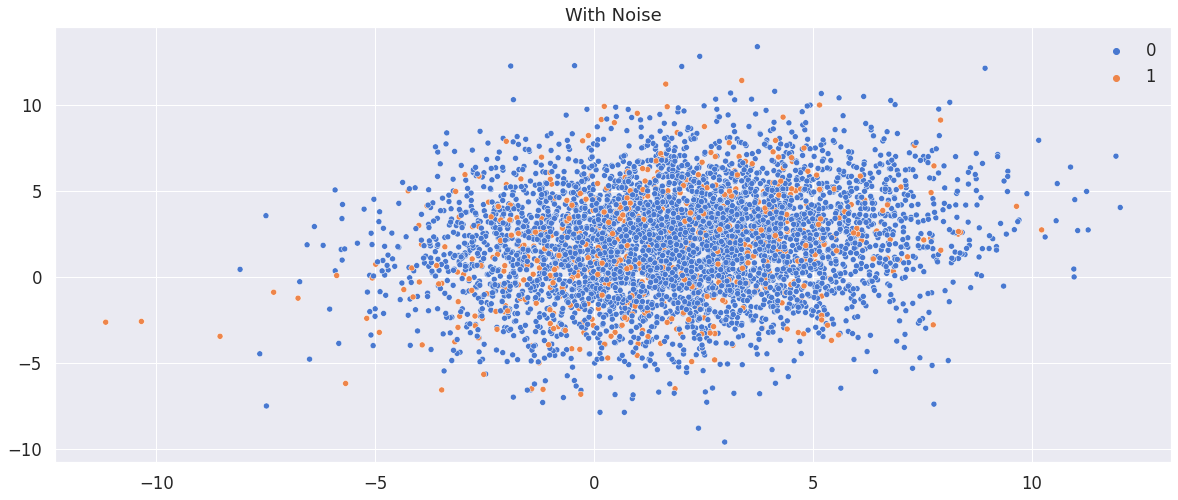

In [3]:
#@title Generate Training Data
%matplotlib inline
import data_pipeline as dp

max_class_ratio=0.99

# get the dataset
X0, y0 = dp.generate_imbalanced_data(class_ratio=max_class_ratio, verbose=1)

In [4]:
#@title Define and Choose Base Classifiers
base_learners = [
                 ('RF', RandomForestClassifier(n_estimators= 200, 
                                                   oob_score = True, 
                                                   class_weight = "balanced", 
                                                   random_state = 20, 
                                                   ccp_alpha = 0.1)), 
                 ('KNNC', KNeighborsClassifier(n_neighbors = len(np.unique(y0))
                                                     , weights = 'distance')),
                #  ('SVC', SVC(kernel = 'linear', probability=True,
                #                    class_weight = 'balanced'
                #                   , break_ties = True)), 

                 ('GNB', GaussianNB()), 
                 ('QDA',  QuadraticDiscriminantAnalysis()), 
                 ('MLPClassifier', MLPClassifier(alpha=1, max_iter=1000)), 
                 # ('DT', DecisionTreeClassifier(max_depth=5)),
                 # ('GPC', GaussianProcessClassifier(1.0 * RBF(1.0))),
                ]

In [5]:
#@title Generate Rating Matrices
import cf_models as cm

tLoadPretrained = False
######################
fold_number = 0
n_iterations = 1
data_dir = os.path.join(input_dir, 'data')

policy_threshold = 'balanced' # Options: 'fmax', 'balanced' ... 
######################

if not tLoadPretrained:  
    # Use the previously selected base predictors (`base_learners`) to generate the level-1 dataset
    R, T, U, L_train, L_test = cm.demo_cf_stacking(input_data=(X0, y0), 
                                                   input_dir=input_dir, n_iter=n_iterations, 
                                                   base_learners=base_learners, # <<< base classifiers selected
                                                   verbose=1)
else: 
    R, T, U, L_train, L_test = dp.load_pretrained_level1_data(fold_number=fold_number, verbose=1, data_dir=data_dir)

# Derived quantities
n_train = R.shape[1]
p_threshold = uc.estimateProbThresholds(R, L=L_train, pos_label=1, policy=policy_threshold)
lh = uc.estimateLabels(T, p_th=p_threshold) # We cannot use L_test (cheating), but we have to guesstimate
L = np.hstack((L_train, lh)) 
X = np.hstack((R, T))

# Calcuate basic statistics on class distributions (on the training set)
class_info = uc.classPrior(L_train)
ratio_majority_to_minority = class_info['r_max_to_min']

assert len(U) == X.shape[0]
assert ratio_majority_to_minority >= 1.0
print(f"> shape(R):{R.shape} || shape(T): {T.shape} => shape(X): {X.shape}")

  0%|          | 0/1 [00:00<?, ?it/s]

(BaseCF) base est | name: RF, estimator: RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced', n_estimators=200,
                       oob_score=True, random_state=20)
(BaseCF) base est | name: KNNC, estimator: KNeighborsClassifier(n_neighbors=2, weights='distance')
(BaseCF) base est | name: GNB, estimator: GaussianNB()
(BaseCF) base est | name: QDA, estimator: QuadraticDiscriminantAnalysis()
(BaseCF) base est | name: MLPClassifier, estimator: MLPClassifier(alpha=1, max_iter=1000)
(BaseCF) Base predictors:
[1]  RF: RandomForestClassifier(ccp_alpha=0.1, class_weight='balanced', n_estimators=200,
                       oob_score=True, random_state=20)
[2]  QDA: QuadraticDiscriminantAnalysis()
[3]  MLPClassifier: MLPClassifier(alpha=1, max_iter=1000)
[4]  KNNC: KNeighborsClassifier(n_neighbors=2, weights='distance')
[5]  GNB: GaussianNB()




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.8s finished


[info] Saving X_meta (shape=(3750, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/train-0.npz

[info] Saving X_meta (shape=(1250, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz

[info] Saving X_meta (shape=(1250, 5)) at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz

[result] 0.08571428571428572
(cf_write) Adding new attribute y:
[0 0 0 0 0 ... 0 1 0 0 0]
...
(cf_write) Saving X_meta at:
/content/drive/MyDrive/Colab Notebooks/machine_learning_examples/cf_ensemble/data/test-0.npz



100%|██████████| 1/1 [01:38<00:00, 98.92s/it]

[info] list of base classifiers:
['RF' 'KNNC' 'GNB' 'QDA' 'MLPClassifier']

R: Rating/probability matrix for the TRAIN set


> shape(R):(5, 3750) || shape(T): (5, 1250) => shape(X): (5, 5000)


#### Verify probability thresholds

In [6]:
from collections import Counter

def select_others(options=['fmax', 'auc', 'balanced'], exclude=[], n=None): 
    if not isinstance(exclude, (list, tuple)): excluce = [exclude, ] 
    others = list(set(options)-set(exclude))
    if n is None: n = len(others)
    return np.random.choice(others, n) # select from options except those in `exclude` list

verify = True
# importlib.reload(pmodel)
# p_threshold = uc.estimateProbThresholds(R, L=L_train, policy=policy_threshold)
if verify: 
    p_thresholds = {}
    X = np.hstack((R, T))
    policies = ['fmax', 'auc', 'balanced', 'uniform', ]
    for policy in policies: # select_others(['fmax', 'auc', 'balanced'], exclude=[policy_threshold, ]): 
        p_th = p_thresholds[policy] = uc.estimateProbThresholds(R, L=L_train, policy=policy)
        lh_1 = uc.estimateLabels(X, p_th=p_th)
        
        print(f"Does policy=`{policy}` lead to a reasonable positive-to-negative ratio?")
        # counts = Counter(lh_1)
        neg, pos = np.bincount(lh_1)
        ratio_pth = neg/(neg+pos)
        print(f"> N(neg): {neg}, N(pos): {pos}")
        print(f"> Ratio(data): {max_class_ratio}, Ratio(p_th): {ratio_pth}")

    print(p_thresholds)

# [observation] `balanced` policy seems more reasonable

(estimateProbThresholds) policy: fmax
Does policy=`fmax` lead to a reasonable positive-to-negative ratio?
> N(neg): 230, N(pos): 4770
> Ratio(data): 0.99, Ratio(p_th): 0.046
Does policy=`auc` lead to a reasonable positive-to-negative ratio?
> N(neg): 3363, N(pos): 1637
> Ratio(data): 0.99, Ratio(p_th): 0.6726
Does policy=`balanced` lead to a reasonable positive-to-negative ratio?
> N(neg): 4743, N(pos): 257
> Ratio(data): 0.99, Ratio(p_th): 0.9486
Does policy=`uniform` lead to a reasonable positive-to-negative ratio?
> N(neg): 4839, N(pos): 161
> Ratio(data): 0.99, Ratio(p_th): 0.9678
{'fmax': array([0.499, 0.   , 0.008, 0.   , 0.005]), 'auc': array([0.501, 0.425, 0.072, 0.   , 0.024]), 'balanced': array([0.501, 0.493, 0.234, 0.   , 0.449]), 'uniform': array([0.5, 0.5, 0.5, 0.5, 0.5])}


#### Configure parameters for the reliability model
- A reliability model attempts to predict the "mask" of the test set using 0-1 encoding, where 0s represent unreliable probabilities and 1s represent reliable proabilities
- Reliability model is a special case of the polarity model, for which each entry of the probability matrix is associated with a richer type (e.g., TP, TN, FP, FN).

In [7]:
#@title Reliability Model Parameters
# import utils_cf as uc
# import polarity_models as pmodel

include_label = True # Set to True to include class labels as part of the training data

# policy_threshold = 'balanced' # Options: 'fmax', 'acc'/'balanced', 'auc'];
# NOTE: `acc` is really "balanced accuracy"


### Using Seq2seq architecture(s) as the polarity model (i.e. generalized "mask")
- Assuming that the ordering of the users (base classifiers) is pre-specified and remains fixed
- By convention, let's denote **X** as the design matrix holding the training data while _**Y**_ represents the label
  - Note that the capitalized italic boldface is used to denote the label (normally in lower case _**y**_) because the label now is a collection of **sequences** representing reliablity of the ratings 
  - This example polarity model falls into the category of **seq2seq** since the training examples are in the form of rating sequences and their corresponding labels are also in the form of sequences; reliability sequences to be specific. 
- Consider the ratings as a sequence of scores, arranged according to the ordering of the users. 
- The goal is then to predict the reliabilty score (polarity) for `T`
  - Reliability score associaed with a rating (T[i, j]) assumes a value, in its discrete form, of either 0 or 1 under 0-1 encoding. 
  - As a **relexation** (and also as a generalization), we will permit the reliabliity score to be any continous values between 0 and 1 (under 0-1 encoding)
  - Recall also that `polarity_models.polarity_matrix()` produces a score of either -1 (negative) and 1 (positive), which is equally legimate represenation for reliablity. 
    - Note that the polarity format (i.e., {-1, 1}-encoding) has the benefit of being easily generalized to incorporate the notion of **colors** (e.g. different types of positive and negative ratings) and **neutral** ratings (for entries that are neither positive nor negative). 
- Assuming that we adopt the 0-1 encoding scheme, then the target label _**Y**_ will consist of sequences of 0s and 1s (totaling `T.shape[1]` sequences), where 0s represent unreliable entries (of T) and 1s represent reliable entries of T. 
- Just like a regular classificaiton problem, the optimization objective is to find a function f() that maps X to _**Y**_ while minimzing a given loss

- We will use a seq2seq neural architecture to learn such a function
  - We will use the binary cross entropy (or BCE) loss for this task because the target label comprises values of either 0 or 1. 
  - Due to this setup (including the chosen loss fucntion), the resulting reliability predictions will not be perfectly 0s and 1s but likely some values that fall within the interval of [0, 1]. 

- Packing all the sequence predictions into a matrix, we then obtain a "prediction matrix" (_**Yh**_) that has the same interpretation as the probabilty filter, which is used to select the entries that ultimately go into the optimization objective for deriving latent factors for users (classifiers) and items (data)
  - If this seq2seq-based polarity model runs sucessfully, then we should expect _**Yh**_ to be close to the true label _**Y**_ in terms of the selected loss criteria such as the BCE loss. 




In [8]:
# import pmodel_pipeline
# importlib.reload(pmodel_pipeline)
include_label = True # include class labels as part of the training data?
augmented = True # When set to True, Y_train will include not only the mask values (as primary supervised signals)
# ... but also supplementary information that helps construct loss functions with desirable properties 
# ... see `cf_models.filter_predict_loss()` for an example of such loss function. 

p_threshold = uc.estimateProbThresholds(R, L=L_train, policy=policy_threshold)
P, _ = pmodel.probability_filter(R, L_train, p_threshold)

# Note that in "demo 5", we'd used the fucntion `make_seq2seq_training_data()` to create training data
# here, we've changed to a different version: `make_seq2seq_training_data2()`
X_train, Y_train = pmodel.make_seq2seq_training_data2(R, Po=P, 
                                                        L=L_train, # True labels for the training set
                                                        p_threshold=p_threshold,
                                                        include_label=include_label, 
                                                        augmented=augmented, 
                                                        verbose=1)

print(f"> shape(R): {R.shape}")
print(f"> shape(X_train): {X_train.shape}, shape(Y_train): {Y_train.shape}")

# For the test set, we do not know the label, which is part of the input sequences in `X_train`; one way to feed the label 
# (which we don't know for the test set) is to use a heuristic such as those obtained from majority vote
L_heuristic = uc.estimateLabels(T, p_th=p_threshold) # this heuristically guessed labeling by default uses majority vote

# Make test set for the filter model (seq2seq)
P_test, _ = pmodel.probability_filter(T, L_test, p_threshold)
X_test, Y_test = pmodel.make_seq2seq_training_data2(T, Po=P_test, 
                                                      L=L_heuristic, # <<< Guessed labels (NOT the same as L_test)
                                                      p_threshold=p_threshold, 
                                                      include_label=include_label, 
                                                      augmented=augmented, 
                                                      verbose=1)

print(f"> shape(T): {T.shape}")
print(f"> shape(X_test): {X_test.shape}, shape(Y_test): {Y_test.shape}")

# Y_train = Y_train.astype(X_train.dtype)
# Y_test = Y_test.astype(X_test.dtype)

[info] shape(X): (3750, 6, 1), shape(Y): (3750, 6, 2)
> shape(R): (5, 3750)
> shape(X_train): (3750, 6, 1), shape(Y_train): (3750, 6, 2)
[info] shape(X): (1250, 6, 1), shape(Y): (1250, 6, 2)
> shape(T): (5, 1250)
> shape(X_test): (1250, 6, 1), shape(Y_test): (1250, 6, 2)


#### Estimate bias parameters

In [9]:
# Count number of unreliable entries and reliable entries in training set matrix
n_users = R.shape[0]

# If the training labels contain class labels ...
if Y_train.shape[1] > n_users: 
    Po_train = Y_train[:, :n_users, 0]
else: 
    Po_train = Y_train[:, :, 0]
# Po_train = (Y_train.squeeze().T).astype(int)

n_neg, n_pos = np.bincount(Po_train.astype(int).ravel()) 
initial_bias = np.log([n_neg/n_pos])
print(f"> initial bias: {initial_bias}")

> initial bias: [-1.065]


In [10]:
# [test] Get some training examples
idx = np.where(X_train[:, -1, 0] == 1)[0] # choose those associated with positive labels 
i = np.random.choice(idx, 1)[0]
print(f"> Training instance X_train[{i}]=\n{X_train[i]}\n")
print(f"> Label instance Y_train[{i}]=\n{Y_train[i]}\n")

print(f"> Sliced polarity matrix at {i}")
Po, Lh = pmodel.probability_filter(R, L_train, p_threshold)
print(Po[:, i][:, None])


> Training instance X_train[137]=
[[0.501]
 [0.   ]
 [0.152]
 [0.   ]
 [0.554]
 [1.   ]]

> Label instance Y_train[137]=
[[1.    0.501]
 [0.    0.   ]
 [0.    0.152]
 [0.    0.   ]
 [1.    0.554]
 [0.    1.   ]]

> Sliced polarity matrix at 137
[[1]
 [0]
 [0]
 [0]
 [1]]


#### Import evaluation metrics

In [11]:
# from keras import metrics
# from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score
# import tensorflow_addons as tfa
def get_metric_name(metrics, index=0):
    return metrics[index].__name__

if augmented: 
    target_metrics = [
     # cm.accuracy, 
     cm.f1, 
    ]
else: 
    target_metrics = [
        # keras.metrics.TruePositives(name='tp'),
        # keras.metrics.FalsePositives(name='fp'),
        # keras.metrics.TrueNegatives(name='tn'),
        # keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        # keras.metrics.Precision(name='precision'),
        # keras.metrics.Recall(name='recall'),
        # keras.metrics.AUC(name='auc'),
        # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        # cm.f1, # f1 score
    ]

2.8.0
Model: "model_LSTM_all_state_h_return_state"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 6, 50),      10400       ['input_1[0][0]']                
                                 (None, 50),                                                      
                                 (None, 50)]                                                      
                                                                                                  
 lstm_1 (LSTM)                  (None, 6, 50)        20200       ['lstm[0][0]',                   
                                                          

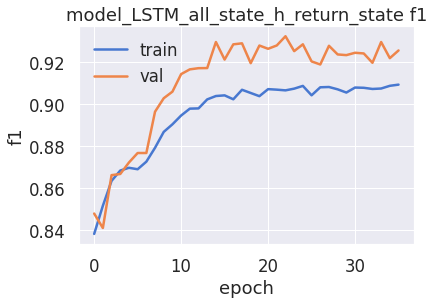

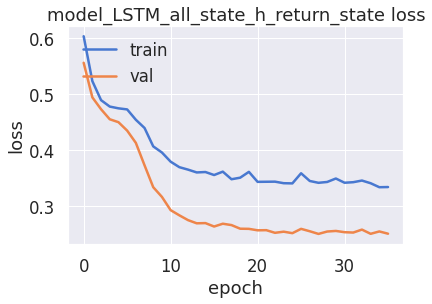

In [12]:
import seq2seq as smodel
# importlib.reload(smodel)
importlib.reload(cm)

method = 'lstm' # Options: 'lstm', 'attention' (encoder-decoder), ...

epochs = 300
batch_size = 64
patience = 20
dropout = 0.2 #

n_users = R.shape[0]
primary_metric = get_metric_name(target_metrics, index=0)
if augmented: 
    loss_fn = cm.filter_predict_loss(alpha=1.0, weight_multiplier=1.0) # weight_multiplier=ratio_majority_to_minority
else: 
    loss_fn = bce = tf.keras.losses.BinaryCrossentropy()

# Model training
############################# 

if method == 'lstm': 
    model_seq = smodel.get_stacked_lstm(n_users if not include_label else n_users+1, # n_users+1: '+1' to include the class labels in the last row)
                                        n_features=1, 
                                        # n_features_out=1,
                                        n_units=n_users*10, # number of LSTM cells
                                        loss=loss_fn, 
                                        activation='sigmoid', 
                                        optimizer=keras.optimizers.Adam(lr=1e-3), 
                                        # output_bias= initial_bias,
                                        dropout=dropout, 
                                        metrics=target_metrics, # performance metrics used for model evaluation
                                        verbose=1)

    history = smodel.train_test(model_seq, X_train, Y_train, X_test, Y_test, 
                                batch_size=batch_size, 
                                patience=patience,
                                metrics=target_metrics, # only used for plotting
                                epochs=epochs, verbose=1)    
    
    
else:   # Use attention model only when dealing with a large ensemble (slower to train and may overfit with small rating matrix)
    batch_size = 1
    epochs = 100

    start_token = [0]
    model_seq = smodel.get_attention_encoder_decoder_model(
                                            n_timesteps= n_users if not include_label else n_users+1, # n_users (+ 1 to include the class labels in the last row)
                                            n_features=1, 
                                            n_units=n_users*4,  # number of LSTM cells

                                            batch_size=batch_size, 

                                            loss=loss_fn, 
                                            activation='sigmoid', 
                                            optimizer=keras.optimizers.Adam(lr=1e-3), # Options: 'adams', 'rmsprop', 
                                            metrics=target_metrics, 

                                            input_encoding='none', 
                                            start_token=start_token, verbose=0)
    
    history = smodel.train_test(model_seq, X_train, Y_train, X_test, Y_test, 
                                batch_size=batch_size, 
                                patience=patience,
                                epochs=epochs, 
                                metrics=target_metrics,
                                verbose=1)


In [13]:
# Evaluating the model on the test set 

loss, score, *other_scores = model_seq.evaluate(X_test, Y_test, batch_size=batch_size)
print(f"> Loss(test): {loss}")
print(f"> {primary_metric.capitalize()}(test): {score}")

# if len(other_scores) > 0: 
#     print(f"F1(test): {other_scores[0]}") # NOTE: Please check `metrics` definition to ensure the indices are as expected

20/20 [==============================] - 1s 11ms/step - loss: 0.4622 - f1: 0.9090
> Loss(test): 0.4621785168647766
> F1(test): 0.9089536725345171


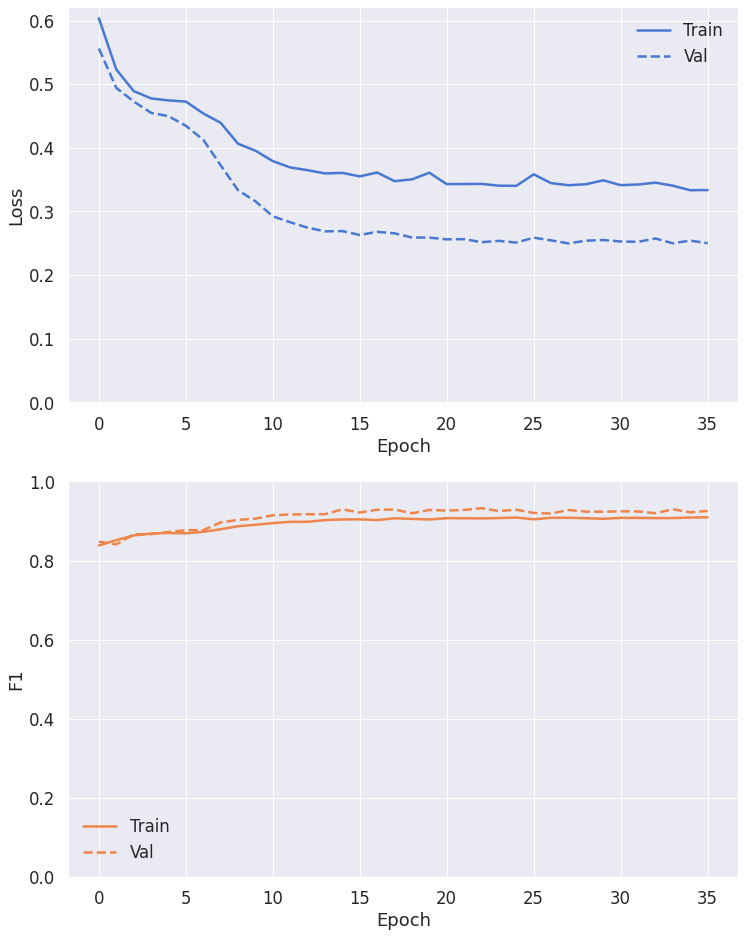

In [14]:
%matplotlib inline
# f, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(20,8))

# plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])
# plt.title("model loss")
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.legend(["train", "test"], loc="upper left")
#plt.show()


def plot_metrics(history, 
                 metrics=['loss', 'accuracy'], # 'prc', 'precision', 'recall'
                 nrows = None, ncols = None):

    if nrows is None: nrows = len(metrics)
    if ncols is None: ncols = 1
    f, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8*nrows))
    # mpl.rcParams['figure.figsize'] = (20, 8)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(nrows, ncols, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[n], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[n], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.7,1])
        elif metric.startswith('acc'):
            plt.ylim([0.2,1])
        else:
            plt.ylim([0,1])

        plt.legend();

plot_metrics(history, metrics=['loss', primary_metric])

In [15]:
# importlib.reload(pmodel)

# Note that `X_test` contains guesstimated label (L_heuristic), which is used only to help us predict the mask for `T`
# The last elements of `Y_test` i.e. Y_test[:, -1, 0] are just a zero paddings to maintain the same sequence length as the inputs in X_test

# L_heuristic = L_test_est = uc.estimateLabels(T, p_th=p_threshold)

# [methods]
# 1. Predict the test set filter as it is
# Y_test_est = model_seq.predict(X_test, batch_size=batch_size)

# 2. Adjust initial label guess and predict using label hypothesis testing method (see pmodel.predict_filter2())
Y_test_est, L_heuristic_adj = pmodel.predict_filter2(model_seq, X_test, 
                                                     batch_size=batch_size, 
                                                     verbose=1, 
                                                     mask_aggregate=False, # Set to True to binarize reliaility prediction (i.e. "soft" filter to mask)
                                                     predict_labels=True) 

# We already know the probability filter for the training set, but we may need the "continuous representation" of the mask
Y_train_est = model_seq.predict(X_train, batch_size=batch_size) 
# Note: we may need the "continuous representation" of the mask (instead of a 0-1 encoded matrix) to infer reliability thresholds

# Estimating labels in the training set as a feedback loop could useful? 
Y_train_est2, L_train_adj = pmodel.predict_filter2(model_seq, X_train, 
                                                     batch_size=batch_size, 
                                                     verbose=1, 
                                                     mask_aggregate=False, 
                                                     predict_labels=True) 
# we know that `L_train` carries the true labels; `L_train_adj` is the prediction from trained sequence model (model_seq) using a form 
# of "hypothesis testing" (see pmodel.predict_filter2())
acc_train_adj = np.sum(L_train_adj == L_train)/len(L_train)
print(f"> Accuracy of adjusted label prediction: {acc_train_adj}")
# This could also tell us which training instances that this sequence model would label wrong; we could potentially use this information to 
# fix our label hypothesis testing in the test set

print(f"> shape(Y_pred): {Y_test_est.shape}") # (1250, 5(+1), 1): n_samples x n_users(+1) x n_features, where +1 if a class label is included
 
print()
i = np.random.choice(range(T.shape[1]), 1)[0]
print(f"> Show example prediciton at i={i}")
print(f"> T[:, {i}]:\n{T[:, i].reshape(-1, 1)}\n> L_test[{i}]: {L_test[i]}")
print(f"> Y_test[{i}]:\n{Y_test[i, 0:n_users, :1]}\n")
print(f"> Y_pred[{i}]:\n{Y_test_est[i, 0:n_users]}\n> L_dummy[{i}] (equal or almost 0?): {Y_test_est[i, n_users]}")

[info] Found n=13 different labeling results wrt the original guess
[info] Found n=382 different labeling results wrt the original guess
> Accuracy of adjusted label prediction: 0.8981333333333333
> shape(Y_pred): (1250, 6, 1)

> Show example prediciton at i=111
> T[:, 111]:
[[0.499]
 [0.   ]
 [0.037]
 [0.   ]
 [0.01 ]]
> L_test[111]: 0
> Y_test[111]:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]

> Y_pred[111]:
[[0.581]
 [0.961]
 [0.964]
 [0.863]
 [0.983]]
> L_dummy[111] (equal or almost 0?): [0.996]


In [16]:
# [test] Get some predicted examples
test_ids = np.random.choice(range(T.shape[1]), 3)
Y_test_est[test_ids, :, :]

array([[[0.577],
        [0.493],
        [0.845],
        [0.031],
        [0.943],
        [0.996]],

       [[0.584],
        [0.96 ],
        [0.958],
        [0.854],
        [0.968],
        [0.996]],

       [[0.585],
        [0.959],
        [0.952],
        [0.854],
        [0.974],
        [0.996]]])

In [17]:
# import pmodel_pipeline
importlib.reload(uc)
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score

n_users = R.shape[0]

# Convert reliability scores in the test set into the matrix format, which is essentially 
# a "probability filter" where 0s represent unreliable entries and 1s represent unreliable entries

# However, the reliability scores as the seq2seq model outputs won't be perfectly 0s and 1s but 
# continous values in [0, 1], which gives us a "soft" probability filter; this is due to the property 
# of the optimization (seq2seq model with BCE loss will not lead to perfect 0-1 scores)
P_test = Y_test_est.squeeze().T
y_pred = None # In this model, we won't have a label prediction like the model in demo 5
if P_test.shape[0] > n_users: 
    y_pred = L_heuristic # use a heuristic as a placeholder here (output sequences from this model does not contain class label predictions)
    y_pred_adj = L_heuristic_adj
    P_test = P_test[:n_users]

    # X_test now carries adjusted labels; how do they compare to the original heuristic?
    print(f"> L_heuristic |     f1: {f1_score(L_test, y_pred)}, balanced acc: {balanced_accuracy_score(L_test, y_pred)}")
    print(f"> L_heuristic_adj | f1: {f1_score(L_test, y_pred_adj)}, balanced acc: {balanced_accuracy_score(L_test, y_pred_adj)}")

# y_pred = P_test[n_users] if P_test.shape[0] > n_users else None

# Since we know the class label for the training set, the (hard) probability filter (aka mask) is a known quantity
# However, getting the soft filter for the training set is helpful for us to estimate the hard filter for the test set (T) later on
P_train = Y_train_est.squeeze().T 
y_train = L_train
if P_train.shape[0] > n_users: 
    # Note that this seq2seq model does not predict labels directly; therefore, the following statement (as in demo 5a) does not make sense
    # y_train_pred = P_train[n_users] # this does NOT hold class label predictions
    
    y_train_pred = L_train_adj
    score = f1_score(y_train, y_train_pred) # np.sum( y_train == y_train_pred ) / len(y_train)

    # There is no direct probability prediction from this version of sequence model; however, we could infer this from the label hypothesis testing
    # as well as the label-induced mask (but this does not work well)
    Y_train_est2, y_train_score = pmodel.predict_filter2(model_seq, X_train, 
                                                         batch_size=batch_size, 
                                                         mask_aggregate=False, 
                                                         predict_proba=True, p_threshold=p_threshold) 
    
    # Given `policy_threshold`, determine the probability threshold and its corresponding performance score
    # p_th = uc.estimate_proba_threshold(y_train, y_train_score, policy=policy_threshold)
    # score_max, p_th = uc.estimate_score_and_threshold(y_train, y_train_score, policy=policy_threshold)
    
    # [test]
    # A special case if policy_threshold = 'balanced' or balanced accuracy
    # acc_max, p_th = uclf.acc_max_score_threshold(y_train, y_train_score) 
    # A special case if policy_threshold = 'fmax' or balanced accuracy
    fmax, p_th = uclf.fmax_score_threshold(y_train, y_train_score, beta=1, pos_label=1)
    
    y_train_pred2 = (y_train_score >= p_th).astype(int)
    score2 = f1_score(y_train, y_train_pred2) # np.sum( y_train == y_train_pred2 ) / len(y_train)
    print(f"> Label prediction on train set labels at p_th={p_th}: f1(label method): {score}, f1(proba method): {score2}") # This is an interesting result
    # NOTE: According to how the output `Y_train` is structured, the last elements of the output sequences (predictions) are supposed to be all 0s
    #       However, wherever the label (L_train) is positive (or 1), we do observe a small non-zero values in the output of the trained model 

    P_train = P_train[:n_users]
# y_pred_train = P_train[n_users] if P_train.shape[0] > n_users else None

print(f"> shape(P_test): {P_test.shape}, shape(P_train): {P_train.shape}")

assert P_train.shape == R.shape 
assert P_test.shape == T.shape

> L_heuristic |     f1: 0.19277108433734938, balanced acc: 0.5525330337559514
> L_heuristic_adj | f1: 0.20915032679738563, balanced acc: 0.558357406515808
> Label prediction on train set labels at p_th=0.023174357289267977: f1(label method): 0.1278538812785388, f1(proba method): 0.19389485585076313
> shape(P_test): (5, 1250), shape(P_train): (5, 3750)


Mask prediction accuracy

In [18]:
# Y_test[:, :, 0] # shape: (bsize, n_users+1, n_features) 
P_true_mask = Y_test[:, :, 0].T[:n_users, :] # the last element is just a zero padding
P_pred_mask = P_test[:n_users, :] # predicted mask (usu. referred to as a filter due to the continous mask values)
P_pred_binarized = (P_pred_mask >= 0.5).astype(int)
acc_mask = np.sum(P_pred_binarized == P_true_mask)/P_true_mask.size
print(f"Mask prediction accuracy (%): {acc_mask * 100}%")

Mask prediction accuracy (%): 84.65599999999999%


#### Intrinsic evaluation on the predicted filter
- How much does the inferred filter match the ground-truth filter (given the class labels)?

In [19]:
# Test basic properties of the learned filters
######################### Test set ###########################
def evalulate_filter(P, X, L, p_threshold, r_threshold=0.5, name='test', metrics=[], show_baseline=True):
    """
    
    Parameters
    ----------
    r_threshold: reliability threshold

    """
    def display(ret, method='predicted_filter', 
                metrics=['balanced_acc', 'f1', 'precision', 'recall'], 
                msg=""): 
        msg += f"> Dataset='{name.capitalize()}', method={method}:\n"
        r_th = ret.get('r_th', '?')
        if isinstance(r_th, (float, str)): 
            msg += f"> ... threshold:    {ret.get('r_th', '?')}\n"
        else: 
            msg += f"> ... threshold:\n{ret.get('r_th', '?')}\n"
        for metric in metrics: 
            msg += f"> ... {metric}: {ret.get(metric, '?')}\n"
        print(msg)

    import evaluate as ev

    n_users, _ = X.shape

    # Compute the true filter values using the true labels
    P_true, _ = pmodel.probability_filter(X, L, p_threshold) # `P_true` is the ground truth where 1s represent reliable probabilities, 0s o.w. 
    P_pred = P.copy() # predicted filter

    rec = {}
    rec['r_th'] = r_th = r_threshold 
    P_pred[P_pred >= r_th] = 1
    P_pred[P_pred < r_th] = 0
    if P_pred.shape[0] > n_users: P_pred = P_pred[:n_users] 
    # P_pred = P_pred.astype(int)

    # rec['acc'] = np.sum(P_pred == P_true)/P_true.size
    rec = ev.calculate_label_metrics(P_true.ravel(), P_pred.ravel())
    rec['r_th'] = r_threshold
    display(rec, method='seq2seq', metrics=['balanced_acc', 'f1', 'precision', 'recall'])
    
    if show_baseline: 
        # How does it fare with majority vote? 
        print("How does it fare with majority vote?")
        print('-' * 50)
        P_maj = pmodel.filter_by_majority_vote(X, p_threshold, pos_label=1, dtype='int') # probability filter by majority vote
        rec['r_th'] = 'n/a'
        # rec['acc'] = np.sum(P_maj == P_true)/P_true.size
        rec = ev.calculate_label_metrics(P_true.ravel(), P_maj.ravel())
        display(rec, method='majority')

r_th = 0.5

# Test set 
evalulate_filter(P_test, T, L_test, p_threshold, r_threshold=r_th, name='test')
print(); print("#" * 50); print()

# Train set 
evalulate_filter(P_train, R, L_train, p_threshold, r_threshold=r_th, name='train')


> Dataset='Test', method=seq2seq:
> ... threshold:    0.5
> ... balanced_acc: 0.6131218771911638
> ... f1: 0.9126514254485837
> ... precision: 0.8454269321632052
> ... recall: 0.9914902038391071

How does it fare with majority vote?
--------------------------------------------------
> Dataset='Test', method=majority:
> ... threshold:    ?
> ... balanced_acc: 0.7551972483487894
> ... f1: 0.9365289882531261
> ... precision: 0.8982373250952392
> ... recall: 0.9782307540073266


##################################################

> Dataset='Train', method=seq2seq:
> ... threshold:    0.5
> ... balanced_acc: 0.7468453628402647
> ... f1: 0.9118571524108874
> ... precision: 0.854269782595022
> ... recall: 0.9777698099676603

How does it fare with majority vote?
--------------------------------------------------
> Dataset='Train', method=majority:
> ... threshold:    ?
> ... balanced_acc: 0.7758616894302688
> ... f1: 0.9115529653753857
> ... precision: 0.8732348111657883
> ... recall: 0.953388

What happens if we try to optimiz reliability thresholds based on some performance criteria?
- If we pick the thresholds (one for each BP/user) to maximize, say, balanced accuracy, it may increase this performance measure but not necessarily the others. Generally, this step does not seem to help. 

---



In [20]:
# importlib.reload(pmodel)

policy_r_threshold = 'fmax' # Options: 'balanced', 'prior' # [hint] 'balanced' seems better
P_train_true, r_th = \
     pmodel.infer_reliability_threshold(X=(R, T), L=L_train, 
                                   P=(P_train, P_test), 
                                   p_th=p_threshold, 
                                   policy_threshold=policy_r_threshold, 
                                   verbose=0)
assert P_train_true.shape == R.shape
assert len(r_th) == R.shape[0]
print(r_th)

# Test set 
evalulate_filter(P_test, T, L_test, p_threshold, r_threshold=r_th[:, None], name='test')
print(); print("#" * 50); print()

# Train set 
evalulate_filter(P_train, R, L_train, p_threshold, r_threshold=r_th[:, None], name='train')

[0.5 0.5 0.5 0.5 0.5]
> Dataset='Test', method=seq2seq:
> ... threshold:
[[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]
> ... balanced_acc: 0.6131218771911638
> ... f1: 0.9126514254485837
> ... precision: 0.8454269321632052
> ... recall: 0.9914902038391071

How does it fare with majority vote?
--------------------------------------------------
> Dataset='Test', method=majority:
> ... threshold:    ?
> ... balanced_acc: 0.7551972483487894
> ... f1: 0.9365289882531261
> ... precision: 0.8982373250952392
> ... recall: 0.9782307540073266


##################################################

> Dataset='Train', method=seq2seq:
> ... threshold:
[[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]
> ... balanced_acc: 0.7468453628402647
> ... f1: 0.9118571524108874
> ... precision: 0.854269782595022
> ... recall: 0.9777698099676603

How does it fare with majority vote?
--------------------------------------------------
> Dataset='Train', method=majority:
> ... threshold:    ?
> ... balanced_acc: 0.7758616894302688
> ... f

At this point, we've obtained our soft filters/masks: `P_train` and `P_test` which represents our mask prediction for training data `R` and test data `T` respectively. They are called "soft" filters because the mask values are not yet binary but continuous values between 0 and 1. 

We also have an adjusted guesstimated labels for the test set `L_heuristic_adj`, which can be used to create a mask with given probability thresholds. 

#### Extrinsic evaluation on the predicted filter 
Using the predicted filter directly for label prediction (i.e. pre-CF stage), how much does it help with the classification problem? 

Assuming that the label was included in the seq2seq model, we can find out how well the probability filter itself can help predict the test-set labels. 

- Probility filter can be used to select the reliable entries, from which to apply appropriate aggregation method to make final predictions.
   - Convert predicted filter into a mask (hard filter) where reliable entries are represented by 1s and unreliable entries are represented by 0s
   - Use softmax to convert the filter into a weight matrix, which is then used to compute the weighted average of the probability matrix (`T`) across BP outputs. 
   - Use the filter to generate new training data by masking unreliable probabilities (see `combiner.mask_given_filter()`)

- Example aggregation methods can be found in `combiner` module.
  - mean 
  - median 
  - majority vote

Now, gather some baseline predictions to compare with

In [21]:
import combiner 
import evaluate as ev

In [22]:
# Gather some baseline predictions with which performance measures are compared
y_pred_mean = np.mean(T, axis=0)
y_pred_median = np.median(T, axis=0)

# Majority-vote label prediction given probability thresholds
lh_maxvote = uc.estimateLabels(T, p_th=p_threshold, pos_label=1)

# Majority-vote probability prediction using the filter induced by majority vote
# - Given the filter/mask, the final probability prediction is given by averging over ONLY reliable probabilities
y_pred_maxvote = combiner.combine(T, p_threshold=p_threshold, aggregate_func='majority')

# Basic stacking
stacker_name = 'logistic'
stacker = LogisticRegression() 
grid = uclf.hyperparameter_template(stacker_name)
meta_clf = uclf.tune_model(stacker, 
                     uclf.hyperparameter_template(stacker_name), 
                     scoring='f1', verbose=0)(R.T, L_train)
y_pred_stacker = meta_clf.predict_proba(T.T)[:, 1] # get estimate of P(y=1|x)
lh_stacker = meta_clf.predict(T.T)

In [23]:
# Examine probability scores 
print(y_pred_stacker[np.where(lh_stacker == 1)[0]])
print(y_pred_stacker[np.where(lh_stacker == 0)[0]])

print()
prob_pos_maxvote = y_pred_maxvote[np.where(lh_maxvote == 1)[0]]
prob_neg_maxvote = y_pred_maxvote[np.where(lh_maxvote == 0)[0]]
print(f"> P(y=1 | policy=maxvote): {np.mean(prob_pos_maxvote)}, probs examples:\n{np.random.choice(prob_pos_maxvote, 10)}\n")
print(f"> P(y=0 | policy=maxvote): {np.mean(prob_neg_maxvote)}, probs examples:\n{np.random.choice(prob_neg_maxvote, 10)}\n")

[0.548 0.529 0.593 0.52  0.569 0.585]
[0.097 0.103 0.125 0.085 0.08  ... 0.081 0.079 0.088 0.079 0.085]

> P(y=1 | policy=maxvote): 0.7376021170692728, probs examples:
[0.987 0.583 0.996 0.956 0.91  0.273 0.996 0.618 0.592 0.529]

> P(y=0 | policy=maxvote): 0.15286703668875037, probs examples:
[0.12  0.168 0.165 0.138 0.13  0.159 0.159 0.115 0.329 0.203]



#### Using seq2seq-predicted filter for predictions (without CF)

- Using the output of the seq2seq model to predict the labels (without going through the collaborative filter stage)
  - Recall also that when `include_table` is set to True, the training set target Y is structured as the sequence of mask values followed by the class label.  
  - As a result `P_train[-1]` corresponds to the row of label predictions

In [24]:
# At this point, `P_test` should be a "soft" filter, not a mask with 0s and 1s
assert pmodel.is_mask(P_test) == False # not pmodel.is_hard_filter(P_test) 
assert not pmodel.is_mask(P_train)

In [25]:
# importlib.reload(combiner)
acc_seq2seq = np.nan # accuracy for the label prediction in T using the reliability model

# 1. Majority vote
lh = lh_maxvote # use majority vote's label estimate as a default in case `include_label` was set to False
# y_pred_maxvote # we've defined this baseline earlier
 
# 2. Unlike the seq2seq model in demo 5, this version doesn't predict the class label directly but instead, 
#    we can use the seq2seq model to infer the best labeling: For each test instance T[:, j], assign either label (positive and negative) 
#    and test which hypothesis best aligned with the corresponding reliability prediction
#    The best labeling for all test instances (in T) results in `L_heuristic_adj`
Pt_s2s_mask, _ = pmodel.probability_filter(T, L_heuristic_adj, p_threshold) # Use `L_heuristic_adj` to induce a mask
y_pred_s2s_mask = y_pred_s2s = combiner.combine_given_filter(T, Pt_s2s_mask, aggregate_func='mean', axis=0) 

# 3. Feed the filter values into softmax to covert it to valid weights followed by taking weighted average
y_pred_filter = combiner.combine_given_filter(T, P_test, axis=0) # if `P_test` is soft, then by default, use "sum" as the aggregation function
assert np.all(y_pred_filter >= 0.0) and np.all(y_pred_filter <= 1.0)
print(y_pred_filter)

# 4. Use the reliability threshold computed earlier (however, as we've seen, usually the good old 0.5 works better anyway)
# Po, r_th = pmodel.infer_reliability_threshold(...)
Pr_mask = pmodel.to_hard_filter(P_train, r_th, inplace=False)
Pt_mask = pmodel.to_hard_filter(P_test, r_th, inplace=False)

# Combine the probability given the hard filter (aka mask)
y_pred_mask = combiner.combine_given_filter(T, Pt_mask, aggregate_func='mean', axis=0) 
# NOTE: `aggregate_func` will apply aggregation operator (e.g. mean) over T[i][j] where Pt_mask == 1 i.e. reliable probabilities only

# 5. Oracle method if we knew the test set labels ("Bayes error")
print("> Oracle prediction: Assuming that we have access to the true label and use that mask as a way to select reliable proabilities")
P_test_true, Lh = pmodel.probability_filter(T, L_test, p_threshold)
y_pred_oracle = combiner.combine_given_filter(T, P_test_true, aggregate_func='mean', axis=0, verbose=1) 

# We could use the training set statistics to find an approprite probability threshold to covert 
# probabilities into crisp class labels (if we choose to). But is this necessary? 
# 
# At the evaluation stage, we have access to the true label. We wish to find if the probabilities are 
# consistent with the true labels; for this purpose, we could use Brier score and log loss to test if 
# the probabilities are "close" to these labels. Alternatively, we could fine-tune the threshold such that 
# it maximizes a given performance measure, say, f1 score, which leads to a fmax. 
# 
# But either way, we do not need to look back on the training set to derive this threshold for the purpose of
# model evaluation.
#############################################
p_th = combiner.estimate_threshold_with_reliable_entries(R, L_train, p_threshold, 
                                                  aggregate_func='mean', 
                                                  policy_threshold=policy_threshold)
print(f"> Train-set-derived probability threshold considering only reliable entries: p_th={p_th}")

# Label prediction based on the training-set-derived threshold
lh_seq2seq = (y_pred_mask >= p_th).astype(int)  
#############################################
# NOTE:
# Coming from a completely different model and inductive bias, this probability threshold 
# in general will not be the same as BPs' thresholds as in `p_threshold`

[0.144 0.134 0.234 0.1   0.088 ... 0.089 0.086 0.112 0.087 0.098]
> Oracle prediction: Assuming that we have access to the true label and use that mask as a way to select reliable proabilities
[combine] `P` is a hard filter with values: [0 1]
> Train-set-derived probability threshold considering only reliable entries: p_th=0.24779250434997346


#### Pre-CF performance comparison
---

In [26]:
# importlib.reload(uclf)
def display(rec, method='predict_by_filter', 
                metrics=['balanced_acc', 'f1', 'auc'], 
                msg=""): 
    msg += f"> Method={method}:\n"
    p_th = rec.get('p_threshold', 'n/a')
    msg += f"... p_th: {p_th}\n"
    for metric in metrics: 
        msg += f"... {metric}: {rec.get(metric, '?')}\n"
    print(msg)
    return msg
def calculate_ranking(metric_to_methods, msg=""): 
    metric_to_methods_sorted = {}
    for metric, method_scores, in metric_to_methods.items():
        greater_is_better = False if metric.lower().find('loss') >= 0 else True
        
        # For each metric, rank the prediction methods
        ranking = sorted([(method, score) for method, score in method_scores if score != '?'], key=lambda x: x[1], reverse=greater_is_better)
        metric_to_methods_sorted[metric] = ranking

        msg += f"> Metric={metric}\n"
        prev_score = 0.0
        for i, (method, score) in enumerate(ranking): 
            if i == 0: 
                msg += f"{method} ({score})"
                prev_score = score
            else: 
                if score == prev_score: 
                    msg += ' = ' + f'{method} ({score})'
                else: 
                    if greater_is_better:  
                        if score < prev_score: 
                            msg += ' > ' + f'{method} ({score})'
                        else:
                            msg = f"Scores should have been sorted in descending order (metric: {metric}, great is better: {greater_is_better}):\n{ranking}\n"
                            raise ValueError(msg)
                    else: 
                        if score > prev_score: 
                            msg += ' < ' + f'{method} ({score})'
                        else: 
                            msg = f"Scores should have been sorted in ascending order (metric: {metric}, great is better: {greater_is_better}):\n{ranking}\n"
                            raise ValueError(msg)
                # Update score
                prev_score = score
        msg += '\n\n'
        
    print(msg)
    return metric_to_methods_sorted


In [27]:
# Performance comparison 
# A. Baseline
#    - L_test: the true labels of the test set 
#    
#    - y_pred_mean: the probability prediction (using the mean across all BPs) 
# 
#    - lh_maxvote: the label prediction using majority vote
#    - y_pred_maxvote: probability prediction using majority vote
#    - y_pred_stacker: probabliity prediction using a stacker (e.g. logistic regression)
# 
# B. Filter-derived 
#    - y_pred_s2s_mask: probability prediction using mask induced by seq2seq-generated labels (i.e. `L_heuristic_adj`)
#    - y_pred_filter: probability prediction via filter-based weighted average 
#    - y_pred_mask: probability prediction by averaging over reliable probabilities according the mask (hard filter)
#    - y_pred_mask_stacker: Apply stacker on masked probabilities (todo)

methods = { # baseline
           "maxvote": y_pred_maxvote, 
           "mean": y_pred_mean, 
           "stacker": y_pred_stacker, 
           
           # seq2seq-induced filter and mask
           "s2s_mask": y_pred_s2s_mask, # probability prediction using L_heuristic_adj to induce a mask, from which to select the reliable probabilities
           "filter": y_pred_filter, # probability prediction using predicted filter (filter values are continuous in [0, 1])
           "mask": y_pred_mask, # probability prediction using predicted mask (i.e. with filter values either 1s or 0s)
           
           # oracle (the best filter one can hope to achieve)
           "oracle": y_pred_oracle, 
           } 

target_metrics = ['balanced_acc', 'f1', 'brier', 'log_loss', 'auc']
y_true = L_test
ranking = {metric: [] for metric in target_metrics}
for method, y_score in methods.items(): 

    # Use the threshold consistent with `policy_threshold`? or just use fmax?
    fmax, p_th = uclf.fmax_score_threshold(y_true, y_score, beta=1, pos_label=1)
    # score_max, p_th = uc.estimate_score_and_threshold(y_true, y_score, policy=policy_threshold, pos_label=1)
    
    metric_scores, metric_labels = ev.calculate_all_metrics(y_true, y_score, p_th=p_th)
    metric_scores.update(metric_labels)
    metric_scores['p_threshold'] = p_th
    
    for metric in target_metrics:
        ranking[metric].append( (method, metric_scores[metric]) ) # within the same performance metric, rank models by their scores

    display(metric_scores, method=method, metrics=target_metrics, msg="")

print("#" * 50); print('\n')
calculate_ranking(ranking)
print("#" * 50); print('\n')

# The Following methods focus on label predictions
methods['maxvote'] = lh_maxvote # label by majority vote directly 
# Note: labeling through majority vote doesn't require inferring a probability threshold

target_metrics = ['balanced_acc', 'f1', ]
for method, y_pred in methods.items(): 
    if uclf.is_label_prediction(y_pred): 
        y_pred_label = y_pred # no-op
    else: 
        fmax, p_th = uclf.fmax_score_threshold(y_true, y_pred, beta=1, pos_label=1)
        # score_max, p_th = uc.estimate_score_and_threshold(y_true, y_pred, policy=policy_threshold, pos_label=1)
        y_pred_label = (y_pred >= p_th).astype(int)
     
    metric_labels = ev.calculate_label_metrics(y_true, y_pred_label)
    display(metric_labels, method=method, metrics=target_metrics, msg="")

> Method=maxvote:
... p_th: 0.14555097725570637
... balanced_acc: 0.5724067832878618
... f1: 0.2228571428571429
... brier: 0.1157511473609596
... log_loss: 0.34023334706732883
... auc: 0.5782913390039052

> Method=mean:
... p_th: 0.3204898261699417
... balanced_acc: 0.5753423741507516
... f1: 0.2402826855123675
... brier: 0.05051632471939649
... log_loss: 0.3593905304862529
... auc: 0.578405017921147

> Method=stacker:
... p_th: 0.15869019415694266
... balanced_acc: 0.5705812336168619
... f1: 0.23744292237442924
... brier: 0.16089479489802094
... log_loss: 0.3238078361992347
... auc: 0.5847509763012892

> Method=s2s_mask:
... p_th: 0.14555097725570637
... balanced_acc: 0.5724067832878618
... f1: 0.2228571428571429
... brier: 0.1341955920994966
... log_loss: 0.33603110814669274
... auc: 0.5785989407799711

> Method=filter:
... p_th: 0.21904311816129293
... balanced_acc: 0.5756299149414219
... f1: 0.23708206686930092
... brier: 0.12454036145291558
... log_loss: 0.3378926878497594
... auc

Convert conditional probabilities into crisp class labels 

In [28]:
from sklearn import metrics

def display(ret, method='predicted_filter', msg=""): 
    msg += f"> Method: {method}\n"
    msg += f"> ... accuracy:     {ret.get('acc', '?')}\n"
    msg += f"> ... balanced acc: {ret.get('balanced_acc', '?')}\n"
    msg += f"> ... f1:           {ret.get('f_beta', '?')}\n"
    print(msg)

# Label prediction via the predicted mask
fmax, p_th = uclf.fmax_score_threshold(L_test, y_pred_mask, beta=1, pos_label=1)
# score_max, p_th = uc.estimate_score_and_threshold(L_test, y_pred_mask, policy=policy_threshold, pos_label=1)

lh_seq2seq = (y_pred_mask >= p_th).astype(int)
acc_seq2seq = np.sum(lh_seq2seq == L_test)/len(L_test)

# Label prediction via the seq2seq-induced mask (`L_heuristic_adj` -> probability filter -> probabilities -> labels)
fmax, p_th = uclf.fmax_score_threshold(L_test, y_pred_s2s_mask, beta=1, pos_label=1)
# score_max, p_th = uc.estimate_score_and_threshold(L_test, y_pred_s2s_mask, policy=policy_threshold, pos_label=1)

lh_s2s_mask = (y_pred_s2s_mask >= p_th).astype(int)
acc_s2s_mask = np.sum(lh_s2s_mask == L_test)/len(L_test)

rec = {}
methods = [('majority vote', lh_maxvote), ('predicted filter', lh_seq2seq), ('s2s mask', lh_s2s_mask), ]
for method, lh in methods: 
    rec['acc'] = np.sum(lh == L_test)/len(L_test)
    rec['balanced_acc'] = metrics.balanced_accuracy_score(L_test, lh) # args: y_true, y_pred
    rec['f_beta'] = metrics.f1_score(L_test, lh)
    display(rec, method=method)


> Method: majority vote
> ... accuracy:     0.8928
> ... balanced acc: 0.5525330337559514
> ... f1:           0.19277108433734938

> Method: predicted filter
> ... accuracy:     0.6528
> ... balanced acc: 0.5855734767025089
> ... f1:           0.23591549295774647

> Method: s2s mask
> ... accuracy:     0.5648
> ... balanced acc: 0.5724067832878618
> ... f1:           0.2228571428571429



### CF stacking (given predicted filter)

In [29]:
# CF parameters
n_factors = 100
alpha = 100.0
conf_measure = 'brier' # Options: 'brier', 'uniform'

# `policy_threshold` should have been defined previously

n_users = R.shape[0]
n_test, n_seq_len, n_features = Y_test_est.shape

In [30]:
# Convert soft filter to a "hard" filter 
# Method 1: Use soft filter from training set to infer reliability threshold, from which to infer the test set filter
# importlib.reload(pmodel)

policy_r_threshold = 'fmax' # Options: 'balanced', 'prior' # [hint] 'balanced' seems better
mask_method = 'predicted_mask' # Options: 'predicted_mask', 'label_mask' 
n_train = R.shape[1]

if mask_method.startswith(("predict", "soft", )): 
    # `Pr_true`: true filter for the training set
    # Pr_true, Lh = uc.probability_filter(R, L_train, p_threshold)
    # Pf_seq2seq = np.hstack((Pr_true, Pt_mask)) # How about using `Pr_mask`? 

    Pf_seq2seq, r_th = pmodel.infer_probability_filter(X=(R, T), 
                                                       L=L_train, 
                                                   P=(P_train, P_test),
                                                   p_th=p_threshold, 
                                                   policy_threshold=policy_r_threshold, 
                                                   use_ground_truth_fitler=True, # set to True so that we use "true" filter for the training set (where labels are known)
                                                   verbose=1) # `r_th`: reliability threshold 
    
    Pf_seq2seq = Pf_seq2seq.astype(int)
    Pfr, Pft = Pf_seq2seq[:, :n_train], Pf_seq2seq[:, n_train:]
    # print(np.unique(Pft))
    assert Pft.shape == Pt_mask.shape
    assert np.allclose(Pt_mask, Pft), np.unique(Pft)
else: 
    Pr_true, Lh = uc.probability_filter(R, L_train, p_threshold)
    Pt = Pt_s2s_mask
    Pf_seq2seq = np.hstack((Pr_true, Pt))

Pf_seq2seq = pmodel.to_polarity(Pf_seq2seq) # Most of the relevant function calls use polarity format (i.e. {-1, 1} encoding)

# NOTE: Logically, whether it's {0, 1} or {-1, 1} encoding is not too important here; however, the polarity format {-1, 1} has the benefit of  
#.      being able to model positive, negative and neutral ratings, which are encoded by 0 (analogous to particles of neutral charge). 
#.      Ratings associated with positive polarity are those that are reliable and are to be included in the optimization for latent factors
#       Ratings with negative polarity are those that are unreliable and are typically left out of the optimization for latent factors
# 
#       Neutral ratings are those with high uncertainty, meaning that we do not have sufficient evidence that 
#.      indicates the reliability of the rating. So far, we have not explicitly modeled this just yet.

n_reliable = (Pf_seq2seq == 1).sum()
n_unreliable = (Pf_seq2seq == -1).sum()
assert n_reliable + n_unreliable == Pf_seq2seq.size
print(f"[info] n_reliable: {n_reliable}, n_unreliable: {n_unreliable}")
print(f"       r_reliable: {n_reliable/Pf_seq2seq.size}, r_unreliable: {n_unreliable/Pf_seq2seq.size}")

# Method 2: Mix hard filter from training set and soft filter from the test set
# P_train, Lh = pmodel.probability_filter(R, L_train, p_threshold)
# P_seq2seq = np.hstack([P_train, P_test])

print(f"[info] Reliability thresholds: {r_th}")

Conflict in reliability matrix estimate: 2636 entries are different
Error rate: 0.14058666666666667
[info] n_reliable: 19871, n_unreliable: 5129
       r_reliable: 0.79484, r_unreliable: 0.20516
[info] Reliability thresholds: [0.5 0.5 0.5 0.5 0.5]


### Evaluting the predicted probability filter using custom metrics
- See module `polarity_model` for a few proposed metrics for (intrinsic) evaluation of the predicted filter
- Part of these evaluations were also demonstrated via `evalulate_filter()` defined earlier.

In [31]:
def f_score(precision, recall, beta=1.0):
    f_beta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) 
    return f_beta

metrics = pmodel.eval_estimated_probability_filter(P_test, T, L_test, p_threshold, eps=1e-3)

highlight("Predicted labels (on T) via seq2seq-based polarity model")
print(f"> Labeling accuracy via predicted mask: {acc_seq2seq}, via label-induced mask: {acc_s2s_mask}")
print(f"> Reliable-to-correct ratio: {metrics['p_overlap']}") # Fraction of entries predicted reliable and are actually correct (TPs or TNs)
print(f"> Precision: {metrics['precision']}, Recall: {metrics['recall']}")
print(f"> Predcitio(TP): {metrics['precision_tp']}, Recall(TP): {metrics['recall_tp']} => f1(TP): {f_score(metrics['precision_tp'], metrics['recall_tp'])}")
print(f"> Error rate: {metrics['p_missed']}") # Probability of predicting reliable but hitting either FPs or FNs

# How does it fair with majority vote? 
###############################################
# labeling by majority vote
lh_maxvote = uc.estimateLabels(T, p_th=p_threshold, pos_label=1)
acc_max_vote = np.sum(lh_maxvote == L_test) / (len(L_test)+0.0)
Pc_maxvote, Lh0 = pmodel.color_matrix(T, lh_maxvote, p_threshold) # Mc: Color matrix evaluated via estimated labels 
Pf_maxvote = pmodel.to_preference(Pc_maxvote, neutral=0.0)
# => {TP, TN}-entries are desirable and thus encoded as 1s in `Pf_maxvote` whereas {FP, FN}-entries are not desirable hence encoded as 0s
metrics = pmodel.eval_estimated_probability_filter(Pf_maxvote, T, L_test, p_threshold, eps=1e-3)

highlight("Predicted labels (on T) via MAJORITY VOTE")
print(f"> Labeling accuracy: {acc_max_vote}")
print(f"> Reliable-to-correct ratio: {metrics['p_overlap']}") # Fraction of entries predicted reliable and are actually correct (TPs or TNs)
print(f"> Precision: {metrics['precision']}, Recall: {metrics['recall']}")
print(f"> P(TP|reliable): {metrics['precision_tp']}, Recall(TP): {metrics['recall_tp']} => f1(TP): {f_score(metrics['precision_tp'], metrics['recall_tp'])}")
print(f"> Error rate: {metrics['p_missed']}") # Probability of predicting reliable but hitting either FPs or FNs

Predicted labels (on T) via seq2seq-based polarity model
> Labeling accuracy via predicted mask: 0.6528, via label-induced mask: 0.5648
> Reliable-to-correct ratio: 0.80848
> Precision: 0.8084798706432207, Recall: 0.9999998020978028
> Predcitio(TP): 0.02223999644160057, Recall(TP): 0.9999928058071524 => f1(TP): 0.04351227312184282
> Error rate: 3.064319019417835e-05
Predicted labels (on T) via MAJORITY VOTE
> Labeling accuracy: 0.8928
> Reliable-to-correct ratio: 0.8928
> Precision: 0.8982371618685877, Recall: 0.9782305604135048
> P(TP|reliable): 0.010721422729161779, Recall(TP): 0.42445737800447475 => f1(TP): 0.020914561887783803
> Error rate: 1.849221114304413e-05


### Filtering the Confidence matrix

In [32]:
# Parameters (all should have been defined at this point)
# alpha = 100.0
# beta = 1.0 
# conf_measure = 'brier' # Options: 'brier', 'uniform', ...
# policy_threshold = 'fmax' 
fold_number = 0

# Combine relevabt matrix quantities from the training split (R) and the test split (T)
X = np.hstack([R, T])
L = np.hstack((L_train, lh_s2s_mask)) # `lh_s2s_mask` was estimated by running the seq2seq model with both labeling hypotheses for each test instance 

# Combine (and re-weight) the confidence scores in the training set and the test set to facilate the CF optimization later on
# Note: Why re-weighting? 
#       We re-weight the confidence matrix so that confidence scores are adjusted to take into account 
#       the disparity in sample sizes (e.g. the size of TPs is usually much smaller than that of TNs in class-imbalanced data)
Pf, C0, Cw, Cn, *rest = \
    uc.evalConfidenceMatrices(X, L, 
                                P=Pf_seq2seq,  # <<< this is the reliability matrix (aka mask) that we learned from seq2seq
                                alpha=alpha, 
                                p_threshold=p_threshold, 
                                conf_measure=conf_measure, 
                                policy_threshold=policy_threshold, 
                                
                                # Optional debug/test parameters 
                                U=U, fold_number=fold_number, 
                                # n_train = n_train, 
                                is_cascade=True,
                                verbose=0)

assert Pf_seq2seq.shape == Cn.shape, f"shape of P(R, T): {Pf_seq2seq.shape}, shape of C(R, T): {Cn.shape}"

print(f"[info] Zeroed out {(Cn.A == 0).sum()} entries =?= n_unreliable: {n_unreliable}") 

# It's possible that C0 has 0s 
print(f"[info] n(zeros) in C0: {(C0.A == 0).sum()}")

(make_cn) Using WEIGHTED confidence matrix to approximate ratings ...
[info] Zeroed out 5744 entries =?= n_unreliable: 5129
[info] n(zeros) in C0: 1135


### Run CF Optimization

[info] target data type: rating
Epoch 1/150
352/352 [==============================] - 7s 16ms/step - loss: 2.3573 - val_loss: 2.2365
Epoch 2/150
352/352 [==============================] - 5s 14ms/step - loss: 1.3144 - val_loss: 0.8743
Epoch 3/150
352/352 [==============================] - 5s 14ms/step - loss: 0.8375 - val_loss: 0.6245
Epoch 4/150
352/352 [==============================] - 5s 14ms/step - loss: 0.4225 - val_loss: 0.3924
Epoch 5/150
352/352 [==============================] - 5s 13ms/step - loss: 0.2863 - val_loss: 0.2797
Epoch 6/150
352/352 [==============================] - 5s 14ms/step - loss: 0.2314 - val_loss: 0.2451
Epoch 7/150
352/352 [==============================] - 5s 13ms/step - loss: 0.2082 - val_loss: 0.2270
Epoch 8/150
352/352 [==============================] - 5s 13ms/step - loss: 0.1952 - val_loss: 0.2105
Epoch 9/150
352/352 [==============================] - 5s 14ms/step - loss: 0.1819 - val_loss: 0.1966
Epoch 10/150
352/352 [============================

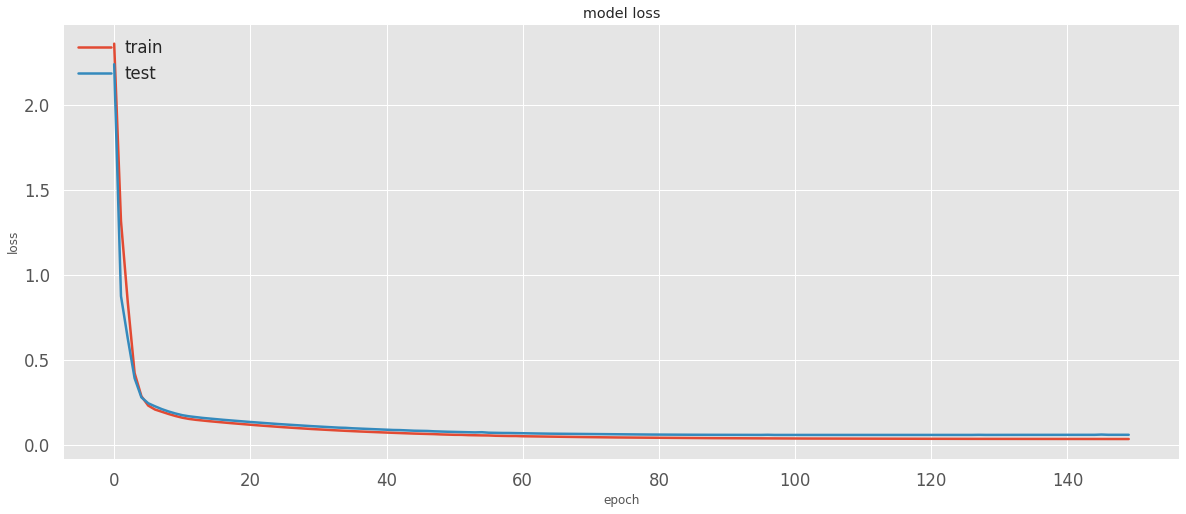

In [33]:
import cf_models as cm

n_users, n_items = X.shape

# fold_number = 0
test_size = 0.1

# policy_threshold = 'fmax'
# conf_measure = 'brier' 
n_factors = 100
# alpha = 100

lr = 0.001 
batch_size = 64
epochs = 150    # NOTE that this is typically is not equal to the epochs required for the polarity model

loss_fn = tf.keras.losses.MeanSquaredError()  # Options: cm.confidence_weighted_loss, cm.c_squared_loss, tf.keras.losses.BinaryCrossentropy(), tf.keras.losses.MeanSquaredError(), ...
cf_model = cm.get_cfnet_compiled(n_users, n_items, n_factors, loss=loss_fn, lr=lr)
# cf_model = cm.get_cfnet_approximating_labels(n_users, n_items, n_factors)

# Configure `target_type` (Options: 'generic', 'rating', 'label')
# 1. Choose 'label' if the BCE loss is used (because the CF model in this case attempts to approximates the label encoded in 0 and 1)
# 2. Choose 'rating' if MSE is used (because the CF model in this case approximates the rating, which is a regression problem)
# 3. Choose 'generic' for customized loss function with potentially more complex labeling information where "y_true" is a matrix 
# 
# Note that you are unlikely need to configure `target_type` because cf_models module has a method that will determine this for you automatically
# target_type = 'label'

cf_model = cm.training_with_predicted_filter(
                                 input_model=(cf_model, loss_fn),  # [todo] incorperate polarity model
                                 input_data={'X': X, # X = np.hstack([R, T]),
                                             'P': Pf_seq2seq, 
                                             'C': Cn,  # Use the filtered confidence matrix Cn
                                             'U': U, 
                                             'L_train': L_train}, 

                                # SGD optimization parameters
                                test_size = test_size,
                                epochs = epochs, 
                                batch_size=batch_size, 

                                # CF hyperparameters
                                # n_factors=n_factors, # this is factored into model definition
                                policy_threshold=policy_threshold,
                                # target_type=target_type,
        
                                fold_number=fold_number) 

### Post-CF Evaluation (1)
- Does collaborative filtering help with classification?
- Compare the results with pre-CF stage performance measures

In [34]:
analyzer = cm.analyze_reconstruction(cf_model, 
                                     X=(R, T),
                                     L=(L_train, lh_s2s_mask), # Note that estimated labels on T (lh_s2s_mask) is only optional; won't be used 
                                     Pc=Pf_seq2seq, p_threshold=p_threshold, policy_threshold=policy_threshold)
highlight("Reestimate the entire rating matrix (X) with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=False)
highlight("Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings")
reestimated = analyzer(L_test, unreliable_only=True, verbose=2)

Reestimate the entire rating matrix (X) with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 33.224126283861416
[info] From T to Th, delta(Frobenius norm)= 17.542425865128433
[info] How different are lh and lh_new? 0.2936
[result] Majority vote: F1 score with the original T:  0.19277108433734938
[result] Majority vote: F1 score with re-estimated Th using original p_threshold: 0.2403846153846154
[result] Majority vote: F1 score with re-estimated Th: 0.22476190476190477

[result] Stacking: F1 score with the original T:  0.08571428571428572
[result] Stacking: F1 score with re-estimated Th: 0.2398190045248869

[result] Best settings (complete): lh_maxvote_new, score: 0.2403846153846154

Reestimate ONLY the unreliable entries in X with learned latent factors/embeddings
[info] From R to Rh, delta(Frobenius norm)= 31.503685903882815
[info] From T to Th, delta(Frobenius norm)= 11.61650147466409
[info] How different are lh and lh_new? 0.0232
[result] Majority vote:

### Post-CF Evaluation (2)

A more comprehensive evaluation ...

In [35]:
# import cf_models as cm
importlib.reload(cm)
from collections import namedtuple

# A CF ensemble dataset consists of several parts: original (rating) matrix, re-estimated matrix, ...
DataSet = namedtuple("DataSet", "X, Xh, L") # `DataSet` type has the attributes: X, Xh and L
Hyperparams = namedtuple("Hyperparams", "alpha, n_factors, policy_threshold, conf_measure")

# The objects associated with traing split
####################################################
# Rh, _ = cm.reestimate(cf_model, R) # We still use cf_model alone to reestimate Rh (no kNN involved)

# hyperparameters are invariant across different prediction strategies
meta = Hyperparams(policy_threshold=policy_threshold,
                   conf_measure=conf_measure, 
                   alpha=alpha, n_factors=n_factors)

# train_split = DataSet(R, Rh, L_train)
####################################################

# A. Reestimate entire matrix
X = np.hstack((R, T))
n_train = R.shape[1]

Rh, Th = cm.reestimate(cf_model, X, n_train=n_train)

train_split = DataSet(R, Rh, L_train)
test_split = DataSet(T, Th, L_test) 
results = cm.analyze_reestimated_matrices(train_split, test_split, meta=meta, include_stacking=True)        


2.8.0
[info] From R to Rh, delta(Frobenius norm)= 33.224126283861416
[info] From T to Th, delta(Frobenius norm)= 17.542425865128433
[info] From `p_threshold(R)` to `p_threshold(Rh)`, delta(2-norm)= 0.551368596939413
...    Original p_threshold:
[0.501 0.493 0.234 0.    0.449]

...    New p_threshold:
[0.498 0.113 0.069 0.102 0.1  ]

> Method=y_pred_mean:
... p_th: 0.3204898261699417
... balanced_acc: 0.5753423741507516
... f1: 0.2402826855123675
... brier: 0.05051632471939649
... log_loss: 0.3593905304862529
... auc: 0.578405017921147

> Method=lh_maxvote:
... p_th: 0
... balanced_acc: 0.5
... f1: 0.19364161849710984
... brier: -0.047215344987120655
... log_loss: 3.702567064381532
... auc: 0.5525330337559513

> Method=y_pred_stacker:
... p_th: 0.15869019415694266
... balanced_acc: 0.5705812336168619
... f1: 0.23744292237442924
... brier: 0.16089479489802094
... log_loss: 0.3238078361992347
... auc: 0.5847509763012892

> Method=y_pred_mean_new:
... p_th: 0.382714049496519
... balanced_a

In [36]:
# B. Reestimate only unreliable entries (better)
Rh, Th = cm.reestimate_unreliable_only(cf_model, X, Pc=Pf_seq2seq, n_train=n_train)

train_split = DataSet(R, Rh, L_train)
test_split = DataSet(T, Th, L_test)
results = cm.analyze_reestimated_matrices(train_split, test_split, meta=meta, include_stacking=True) 

[info] From R to Rh, delta(Frobenius norm)= 31.503685903882815
[info] From T to Th, delta(Frobenius norm)= 11.61650147466409
[info] From `p_threshold(R)` to `p_threshold(Rh)`, delta(2-norm)= 0.5369796781240082
...    Original p_threshold:
[0.501 0.493 0.234 0.    0.449]

...    New p_threshold:
[0.501 0.105 0.228 0.102 0.092]

> Method=y_pred_mean:
... p_th: 0.3204898261699417
... balanced_acc: 0.5753423741507516
... f1: 0.2402826855123675
... brier: 0.05051632471939649
... log_loss: 0.3593905304862529
... auc: 0.578405017921147

> Method=lh_maxvote:
... p_th: 0
... balanced_acc: 0.5
... f1: 0.19364161849710984
... brier: -0.047215344987120655
... log_loss: 3.702567064381532
... auc: 0.5525330337559513

> Method=y_pred_stacker:
... p_th: 0.15869019415694266
... balanced_acc: 0.5705812336168619
... f1: 0.23744292237442924
... brier: 0.16089479489802094
... log_loss: 0.3238078361992347
... auc: 0.5847509763012892

> Method=y_pred_mean_new:
... p_th: 0.14914410898212596
... balanced_acc: 

Playground